In [9]:
import numpy
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils.validation import column_or_1d

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

dev = qml.device("default.qubit", wires=4)


def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [6]:
np.random.seed(1)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("leak.csv", encoding='latin1')

selected_vars = ["DM",  "KOURENI" , "ACSP", "NOCOIL"]
# Extract only the selected variables and the target variable
df_selected = df[selected_vars + ["LEAK"]]

df_selected["DM"] = df_selected["DM"].replace({"NE": 0, "ANO": 1})
df_selected["KOURENI"] = df_selected["KOURENI"].replace({"NEKURÁK": 0, "KURÁK": 1})
df_selected["NOCOIL"] = df_selected["NOCOIL"].replace({"NO": 0, "YES": 1})
df_selected["ACSP"] = df_selected["ACSP"].replace({"NO": 0, "YES": 1})
df_selected["ACSP"] = df_selected["ACSP"].replace({"No": 0, "Yes": 1})
df_selected["LEAK"] = df_selected["LEAK"].replace({"leak se nevyskytl": 0, "leak se vyskytl": 1})

df = df_selected
df = df.sample(n=100)

# Separate features (X) and target variable (y)
d = df.drop("LEAK", axis=1)
X = d.to_numpy()
Y = df.to_numpy()[:,4]
Y[Y == 0] = -1
# Load the data from the file into a NumPy array


C:\Users\petre\AppData\Local\Temp\ipykernel_29796\1296536983.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_selected["DM"] = df_selected["DM"].replace({"NE": 0, "ANO": 1})
C:\Users\petre\AppData\Local\Temp\ipykernel_29796\1296536983.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["DM"] = df_selected["DM"].replace({"NE": 0, "ANO": 1})
C:\Users\petre\AppData\Local\Temp\ipykernel_29796\1296536983.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future

In [25]:
np.random.seed(1)

num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

[[[ 0.01624345 -0.00611756 -0.00528172]
  [-0.01072969  0.00865408 -0.02301539]
  [ 0.01744812 -0.00761207  0.00319039]
  [-0.0024937   0.01462108 -0.02060141]]

 [[-0.00322417 -0.00384054  0.01133769]
  [-0.01099891 -0.00172428 -0.00877858]
  [ 0.00042214  0.00582815 -0.01100619]
  [ 0.01144724  0.00901591  0.00502494]]] 0.0
Iter:     1 | Cost: 1.7573940 | Accuracy: 0.8800000 
Iter:     2 | Cost: 1.7538648 | Accuracy: 0.8800000 
Iter:     3 | Cost: 1.4252542 | Accuracy: 0.4000000 
Iter:     4 | Cost: 1.6026716 | Accuracy: 0.8800000 
Iter:     5 | Cost: 0.8168356 | Accuracy: 0.8800000 
Iter:     6 | Cost: 0.5710313 | Accuracy: 0.8800000 
Iter:     7 | Cost: 0.5106122 | Accuracy: 0.8800000 
Iter:     8 | Cost: 0.9710478 | Accuracy: 0.8800000 
Iter:     9 | Cost: 1.1065262 | Accuracy: 0.2500000 
Iter:    10 | Cost: 0.5845725 | Accuracy: 0.8800000 
Iter:    11 | Cost: 2.6887649 | Accuracy: 0.2100000 
Iter:    12 | Cost: 0.8282978 | Accuracy: 0.8800000 
Iter:    13 | Cost: 0.7439722 | Accu

In [10]:
num_folds = 10
seed = 7
scoring = 'accuracy'

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
Y_train_1d = column_or_1d(Y_train)
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, Y_train_1d, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.887500 (0.117925)
LDA: 0.875000 (0.136931)
KNN: 0.862500 (0.130504)
CART: 0.875000 (0.136931)
NB: 0.812500 (0.139754)
SVM: 0.862500 (0.130504)


In [11]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, Y_train_1d, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\petre\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\petre\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\petre\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\petre\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

AB: 0.875000 (0.125000)
GBM: 0.887500 (0.117925)
RF: 0.887500 (0.103833)
ET: 0.875000 (0.136931)


C:\Users\petre\AppData\Local\Temp\ipykernel_14212\2525800941.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


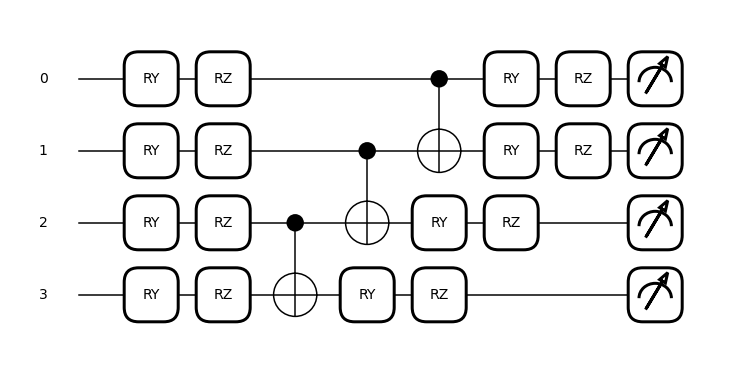

In [68]:
@qml.qnode(dev)
def custom_circuit(theta):
    for i in range(4):
        qml.RY(theta[i], wires=i)
        qml.RZ(theta[i + 4], wires=i)

    for i in range(2,0,-1):
        qml.CNOT(wires=[i, i+1 ])
    qml.CNOT(wires=[0,1])
    for i in range(4):
        qml.RY(theta[i + 8], wires=i)

    for i in range(4):
        qml.RZ(theta[i + 12], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

x=np.zeros(16)

fig, ax = qml.draw_mpl(circuit)(x)
fig.show()

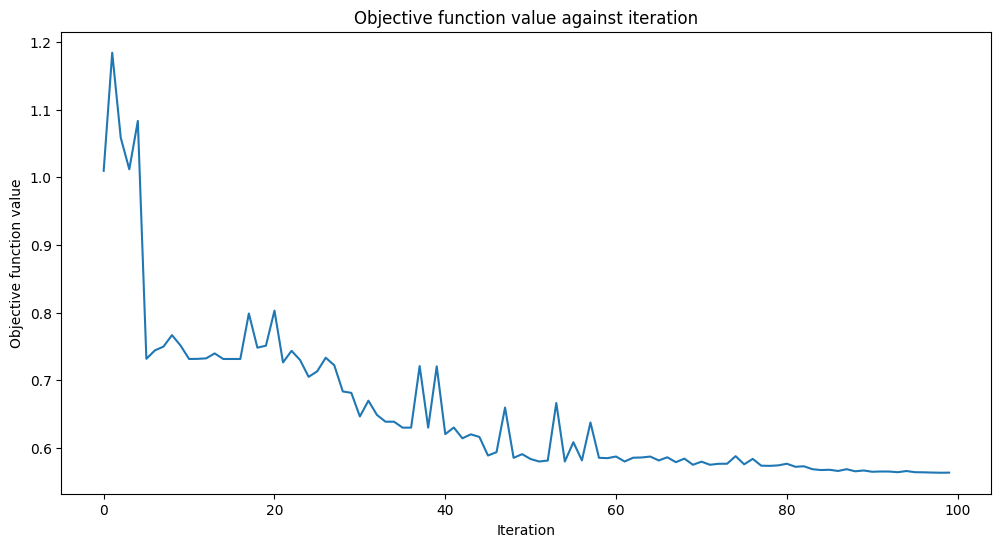

Training time: 66 seconds


In [8]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)
from qiskit.primitives import Sampler

sampler = Sampler()
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X, Y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [12]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_validation, Y_validation)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.90
Quantum VQC on the test dataset:     0.85


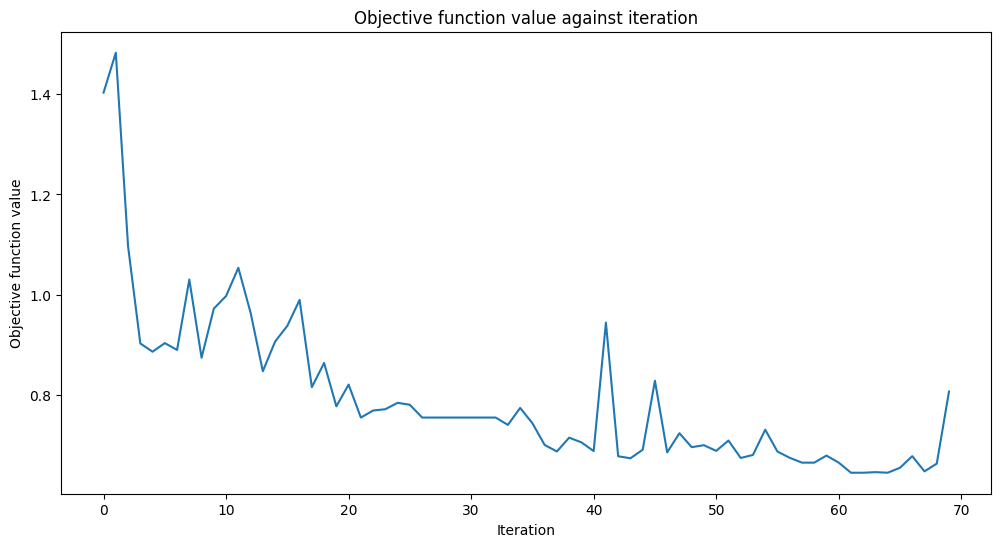

Training time: 61 seconds


In [15]:
from qiskit.circuit.library import EfficientSU2
ansatz = EfficientSU2(num_qubits=4, reps=3)
feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
optimizer = COBYLA(maxiter=70)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X, Y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [16]:
train_score_q2_eff = vqc.score(X_train, Y_train)
test_score_q2_eff = vqc.score(X_validation, Y_validation)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.89
Quantum VQC on the test dataset using EfficientSU2:     0.85
